In [1]:
import seqpandas as spd 
from seqpandas import pathing
from Bio import SeqIO
import gzip
import numpy as np

# Sample files used

In [2]:
gbk = 'tests/test-data/GCF_000013425.1.gbk.gz'
fasta = 'tests/test-data/random_sequences.fasta.gz'

# Fasta to Pandas DataFrame example

In [3]:
fasta_df = spd.read_seq(fasta, format='fasta')
fasta_df.head(3)

,_seq,id,name,description,dbxrefs,annotations,_per_letter_annotations,features
0,"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",FWIRNKE01DKIF6,FWIRNKE01DKIF6,FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],{},{},[]
1,"(G, C, G, A, G, C, A, G, C, A, A, T, C, A, T, ...",FWIRNKE01CDBE3,FWIRNKE01CDBE3,FWIRNKE01CDBE3 rank=0000320 x=854.0 y=2685.0 l...,[],{},{},[]
2,"(C, G, A, G, C, A, G, C, A, C, A, T, C, A, T, ...",FWIRNKE01BKZJJ,FWIRNKE01BKZJJ,FWIRNKE01BKZJJ rank=0000535 x=531.0 y=3933.0 l...,[],{},{},[]


# You can also import seqrecords directly from BioPythons parsing output.

In [5]:
with gzip.open(fasta, "rt") as handle:
    seqrecords = SeqIO.parse(handle, format='fasta')
    fasta_df = spd.BioDataFrame.from_seqrecords(seqrecords)
fasta_df.head(3)

,_seq,id,name,description,dbxrefs,annotations,_per_letter_annotations,features
0,"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",FWIRNKE01DKIF6,FWIRNKE01DKIF6,FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],{},{},[]
1,"(G, C, G, A, G, C, A, G, C, A, A, T, C, A, T, ...",FWIRNKE01CDBE3,FWIRNKE01CDBE3,FWIRNKE01CDBE3 rank=0000320 x=854.0 y=2685.0 l...,[],{},{},[]
2,"(C, G, A, G, C, A, G, C, A, C, A, T, C, A, T, ...",FWIRNKE01BKZJJ,FWIRNKE01BKZJJ,FWIRNKE01BKZJJ rank=0000535 x=531.0 y=3933.0 l...,[],{},{},[]


# Search description with little effort!

In [6]:
# I want all ranks of a certain number 
fasta_df[fasta_df['description'].str.contains('rank=0000177')]

,_seq,id,name,description,dbxrefs,annotations,_per_letter_annotations,features
0,"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",FWIRNKE01DKIF6,FWIRNKE01DKIF6,FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],{},{},[]


# Better view of the layout for a single row

In [7]:
fasta_df.head(1).to_dict('records')

[{'_seq': Seq('CGATATTCGATCCGCATCGCTGCCCTACCCGTGGAGTGCCTCCCTCGGNGCAG'),
  'id': 'FWIRNKE01DKIF6',
  'name': 'FWIRNKE01DKIF6',
  'description': 'FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 length=53',
  'dbxrefs': [],
  'annotations': {},
  '_per_letter_annotations': {},
  'features': []}]

# GenBank to Pandas DataFrame example

In [8]:
gbk_df = spd.read_seq(gbk, format='genbank')
gbk_df.head(3)

,_seq,id,name,description,dbxrefs,_per_letter_annotations,molecule_type,topology,data_file_division,date,...,codon_start,transl_table,product,protein_id,translation,EC_number,pseudogene,gene_synonym,experiment,pseudo
0,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,[1],[11],[chromosomal replication initiation protein],[YP_498609.1],[MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSS...,NaN,NaN,NaN,NaN,NaN


# See all the possible columns of meta data

In [9]:
gbk_df.columns

Index(['_seq', 'id', 'name', 'description', 'dbxrefs',
       '_per_letter_annotations', 'molecule_type', 'topology',
       'data_file_division', 'date', 'accessions', 'sequence_version',
       'keywords', 'source', 'organism', 'taxonomy', 'references', 'comment',
       'contig', 'location', 'type', 'mol_type', 'strain', 'sub_species',
       'db_xref', 'gene', 'locus_tag', 'note', 'codon_start', 'transl_table',
       'product', 'protein_id', 'translation', 'EC_number', 'pseudogene',
       'gene_synonym', 'experiment', 'pseudo'],
      dtype='object')

# Seach for only rows of type CDS

In [11]:
cds = gbk_df[gbk_df.type == 'CDS']
gene = gbk_df[gbk_df.type == 'gene']
print('Genome has CDS count:', cds.shape)
print('Genome has GENE count:', gene.shape)

Genome has CDS count: (2767, 38)
Genome has GENE count: (2872, 38)


In [12]:
cds.head(3)

,_seq,id,name,description,dbxrefs,_per_letter_annotations,molecule_type,topology,data_file_division,date,...,codon_start,transl_table,product,protein_id,translation,EC_number,pseudogene,gene_synonym,experiment,pseudo
2,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,[1],[11],[chromosomal replication initiation protein],[YP_498609.1],[MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSS...,NaN,NaN,NaN,NaN,NaN
4,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,[1],[11],[DNA polymerase III subunit beta],[YP_498610.1],[MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVIL...,[2.7.7.7],NaN,NaN,NaN,NaN
6,"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",NC_007795.1,NC_007795,Staphylococcus aureus subsp. aureus NCTC 8325 ...,"[BioProject:PRJNA57795, Assembly:GCF_000013425.1]",{},DNA,circular,CON,03-AUG-2016,...,[1],[11],[hypothetical protein],[YP_498611.1],[MIILVQEVVVEGDINLGQFLKTEGIIESGGQAKWFLQDVEVLING...,NaN,NaN,NaN,NaN,NaN


# Better view of the layout for a single row

In [13]:
cds.head(1).to_dict('records')

[{'_seq': Seq('CGATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAACATCACCAT...TAT'),
  'id': 'NC_007795.1',
  'name': 'NC_007795',
  'description': 'Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome',
  'dbxrefs': ['BioProject:PRJNA57795', 'Assembly:GCF_000013425.1'],
  '_per_letter_annotations': {},
  'molecule_type': 'DNA',
  'topology': 'circular',
  'data_file_division': 'CON',
  'date': '03-AUG-2016',
  'accessions': ['NC_007795'],
  'sequence_version': 1,
  'keywords': ['RefSeq'],
  'source': 'Staphylococcus aureus subsp. aureus NCTC 8325',
  'organism': 'Staphylococcus aureus subsp. aureus NCTC 8325',
  'taxonomy': ['Bacteria',
   'Firmicutes',
   'Bacilli',
   'Bacillales',
   'Staphylococcaceae',
   'Staphylococcus'],
  'references': [Reference(title='The Staphylococcus aureus NCTC8325 Genome', ...),
   Reference(title='Direct Submission', ...),
   Reference(title='Direct Submission', ...)],
  'comment': 'REVIEWED REFSEQ: This record has been curated by NCBI 

------

# Machine Learning Example Application

### For simplicity of this example we will pretend we have a large sample set, but really we just using the single genbank genome. The follow will create the feature table we can use for a simple Sequential model.
1. Sample the first 4 genes
2. Given them random mutation value from 0 to 20
3. Give each mutation a random "observed in healthy patient"

In [14]:
# Sample for the first 4 genes
genes = [gene[0] for gene in gbk_df[(gbk_df.type == 'gene') & ~gbk_df.gene.isna()]['gene'][:4].values]
genes

['dnaA', 'recF', 'rplI', 'argJ']

In [17]:
# Create fake observed mutation rates for target genomes compared to a reference genome
mutation_array = lambda : list(np.random.uniform(low=0, high=20, size=(1, 100))[0])
observed_gene_mutation_per_genome = spd.BioDataFrame.from_dict({gene:mutation_array() for gene in genes})
observed_gene_mutation_per_genome.head(3)

,dnaA,recF,rplI,argJ
0,5.470563,19.242406,1.763627,17.773504
1,0.525011,2.298095,1.344254,1.815636
2,19.226728,2.126331,16.821579,13.467762


In [18]:
# Give a 0 or 1 to show if a patient has the fake disease
# We a biased 30 percent with disease  
patients = np.zeros(100)
patients[:30] = 1
np.random.shuffle(patients)

observed_gene_mutation_per_genome['fake_disease'] = list(patients)
observed_gene_mutation_per_genome.head(10)

,dnaA,recF,rplI,argJ,fake_disease
0,5.470563,19.242406,1.763627,17.773504,1.0
1,0.525011,2.298095,1.344254,1.815636,0.0
2,19.226728,2.126331,16.821579,13.467762,1.0
3,19.314712,1.957057,18.395884,16.989597,0.0
4,5.778428,19.743984,19.671500,14.353111,0.0
5,15.141159,14.376695,4.884112,12.563653,0.0
6,19.045423,17.280185,17.711694,7.258818,0.0
7,4.588786,4.565258,16.608461,0.441742,0.0
8,0.542041,2.096888,18.780869,14.548252,1.0
9,3.525264,7.665830,1.038490,8.947828,0.0


# optional downloads
```bash
pip install scikit-learn
pip install tensorflow
pip install matplotlib
```

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score

import pandas as pd  # tensorflow is picky with core Pandas naming scheme

In [16]:
df = observed_gene_mutation_per_genome
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:4], df['fake_disease'],
                                                    test_size = 0.33, random_state = 100)

# Create general sequential model with 4 layers  

In [17]:
model = Sequential()

model.add(Dense(4, activation = 'relu')) # 4 for just random guessing
model.add(Dense(4, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1)) # just want healthy status; hence final layer is 1

model.compile(optimizer='rmsprop', loss='mse') # mean squared error for sanity checking

In [18]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)
model.fit(
    x = X_train.to_numpy().astype('float32'), # float32 to save memory and runtime; we dont need 64 bits anyway
    y = y_train.to_numpy().astype('float32'), 
    verbose = 1, # 0 if you dont want to see the print out
    epochs = 100, # number of training intervals 
    # callbacks = [early_stop], # cant used validation set to have an educated stop due to data set being too small :(
    # validation_data=(X_test.astype('float32'), y_test.astype('float32')), # data too small to use as a validator
)

Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 3.3702
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 2.6729
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 2.1922
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9241
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 1.7955
Epoch 6/100
3/3 [==============================] - 0s 950us/step - loss: 1.6933
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 1.5777
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 1.4495
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 1.3545
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 1.2412
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 1.1382
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 1.0580
Epoch 13/100
3/3 [==============================] - 0s 1ms/

# Check how well your model was built

<AxesSubplot:>

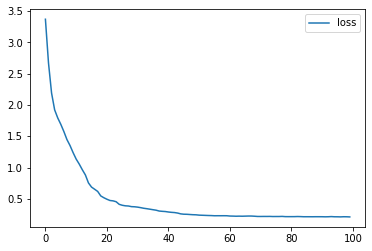

In [19]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [20]:
model # Thats exciting! This is also a word of caution that you can make a model from anything. 

--------